## Exercício: Modelo de Linguagem com auto-atenção

Este exercício é similar ao da aula passada, mas iremos agora treinar uma rede neural *com auto-atenção* para prever a próxima palavra de um texto, data as palavras anteriores como entrada.

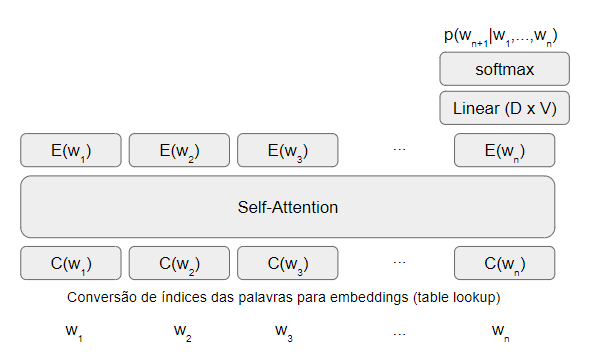

Na camada de auto-atenção, deve-se implementar (vide slide 41):
- Embeddings de posição
- Projeções lineares (WQ, WK, WV, WO)
- Camada de feed forward (2-layer MLP)



Instrucões:
- É necessário fazer duas implementações da camada de auto-atenção: uma usando laços (ineficiente, mas fácil de entender) e outra matricial (eficiente mas difícil de entender). Usar slide 41 como referência.

- Fazer um assert para garantir que o resultado das duas implementações é exatamente igual.

- No treinamento, usar apenas a implementação matricial.

## Faz download e carrega o dataset

In [1]:
import os
import re
import torch
import torch.nn as nn
import random
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim

from collections import Counter

from typing import Sequence
from typing import Iterable, List, Dict
from typing import Literal

from dataclasses import dataclass

In [2]:
!git clone https://github.com/ethelbeluzzi/projetomachado

Cloning into 'projetomachado'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 65 (delta 24), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (65/65), 7.21 MiB | 3.48 MiB/s, done.
Resolving deltas: 100% (24/24), done.


In [3]:
DATA_PATH = os.path.join("projetomachado", "textonormalizado1000.txt")

In [4]:
def read_corpus(path: str) -> Sequence[str]:
    """
    Lê um arquivo de texto e retorna uma lista de parágrafos.
    """

    # Abre o arquivo e lê suas linhas, removendo espaços em branco e linhas vazias
    with open(path, "r") as data_file:
        data_text = [line.strip() for line in data_file if line.strip()]

    corpus = []  # Lista para armazenar os parágrafos processados
    current_paragraph = ""  # String que acumula as linhas até formar um parágrafo completo

    # Itera sobre as linhas do texto
    for i, line in enumerate(data_text):
        # Verifica se a linha termina com pontuação indicando o fim de uma frase
        if line[-1] in (".", "!", "?"):
            # Se sim, adiciona a linha ao parágrafo atual e finaliza o parágrafo
            current_paragraph += line
            corpus.append(current_paragraph)  # Armazena o parágrafo completo na lista corpus
            current_paragraph = ""  # Reinicia para começar um novo parágrafo
        else:
            # Caso contrário, continua acumulando a linha no parágrafo atual
            current_paragraph += f"{line} "

    # Adiciona o último parágrafo, caso não tenha sido finalizado dentro do loop
    if current_paragraph:
        corpus.append(current_paragraph.strip())  # Remove espaços extras antes de adicionar

    return corpus, data_text  # Retorna a lista de parágrafos e as linhas do arquivo

corpus, data_text = read_corpus(DATA_PATH) # Chama a função e armazena os resultados

# Número total de caracteres no dataset
len(data_text)

305276

In [5]:
# Dados já foram separados em linhas
# Checar tamanho das linhas em caracteres, por curiosidade
lines = []
line_lens = []

with open(DATA_PATH, "r") as data_file:
    for line in data_file:
        lines.append(line)
        line_lens.append(len(line))

In [6]:
lines[0]

'1\n'

In [7]:
# Limpar linhas, removendo \n, espaços antes e depois
with open(DATA_PATH, "r") as data_file:
    cleaned_lines = [line.strip().lower() for line in data_file]

len(cleaned_lines)

306409

In [8]:
# Quantidade total de caracteres após limpeza
acum_chars = 0
for cleaned_line in cleaned_lines:
    acum_chars += len(cleaned_line)

acum_chars

18539036

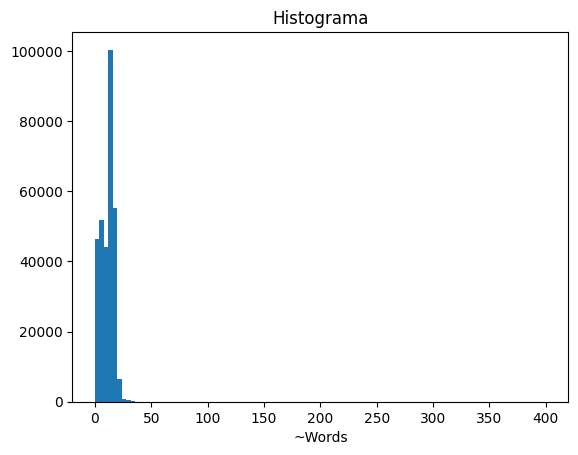

In [9]:
# Check data distribution
line_lens = [len(line.split()) for line in lines]
plt.title("Histograma")
plt.hist(line_lens, bins=100, range=(0, 400))
plt.xlabel("~Words")
plt.show()

In [10]:
lines = read_corpus(DATA_PATH)

print("Corpus lines:", len(lines))
lines[:10]

Corpus lines: 2


(['1 MINISTÉRIO DA CULTURA Fundação Biblioteca Nacional Departamento Nacional do Livro A MÃO E A LUVA Machado de Assis I O fim da carta Mas que pretendes fazer agora?',
  'Morrer.',
  'Morrer? Que idéia! Deixate disso, Estêvão. Não se morre por tão pouco...',
  'Morrese. Quem não padece estas dores não as pode avaliar. O golpe foi profundo, e o meu coração é pusilânime; por mais aborrecível que pareça a idéia da morte, pior, muito pior do que ela, é a de viver. Ah! tu não sabes o que isto é?',
  'Sei: um namoro gorado...',
  'Luís!',
  '... E se em cada caso de namoro gorado morresse um homem, tinha já diminuído muito o gênero humano, e Malthus perderia o latim. Anda, sobe.',
  'Estêvão meteu a mão nos cabelos com um gesto de angústia; Luís Alves sacudiu a cabeça e sorriu. Achavamse os dois no corredor da casa de Luís Alves, à rua da Constituição,  que então se chamava dos Ciganos;  então, isto é, em 1853, uma bagatela de vinte anos que lá vão, levando talvez consigo as ilusões do leit

In [11]:
# Separar em treino e teste
limit = int(0.8*len(cleaned_lines))
train_cleaned_lines = cleaned_lines[:limit]
val_cleaned_lines = cleaned_lines[limit:]

In [12]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 7.7 MB/s eta 0:00:00


In [13]:
from unidecode import unidecode

class Tokenizer:
    """
    Classe Tokenizer para tokenizar, ajustar e codificar textos.
    """

    def __init__(self,
                 max_tokens: int,
                 token_pattern: str = r"\b[^\W\d_]\w*\b|[^\w\s]+",
                 strip_accents: bool = False,
                 lowercase: bool = True,
                 vocabulary: Iterable[str] = None):
        """
        Inicializa o Tokenizer com as opções especificadas.

        Args:
            max_tokens (int): Número máximo de tokens a serem armazenados no vocabulário.
            token_pattern (str): Expressão regular para identificar os tokens.
            strip_accents (bool): Se True, remove acentos dos textos.
            lowercase (bool): Se True, converte os textos para minúsculas.
            vocabulary (Iterable[str]): Vocabulário inicial opcional.
        """
        self.max_tokens = max_tokens
        self.token_pattern = re.compile(token_pattern)
        self.strip_accents = strip_accents
        self.lowercase = lowercase
        self._oov = 0  # Índice para palavras fora do vocabulário
        self._vocabulary: Dict[str, int] = {}

        if vocabulary:
            self.fit(vocabulary)

    def __len__(self) -> int:
        """Retorna o número total de tokens no vocabulário, incluindo o token OOV."""
        return 1 + len(self._vocabulary)

    def __getitem__(self, word: str) -> int:
        """Retorna o índice do token ou o índice OOV se o token não estiver no vocabulário."""
        return self._vocabulary.get(word, self._oov)

    def items(self):
        """Retorna os itens do vocabulário como pares (token, índice)."""
        return self._vocabulary.items()

    def _preprocess(self, text: str) -> str:
        """
        Pré-processa o texto aplicando as opções de minúsculas e remoção de acentos.

        Args:
            text (str): Texto a ser pré-processado.

        Returns:
            str: Texto pré-processado.
        """
        if self.lowercase:
            text = text.lower()
        if self.strip_accents:
            text = unidecode(text)
        return text

    def split(self, text: str) -> List[str]:
        """
        Divide o texto em tokens usando a expressão regular.

        Args:
            text (str): Texto a ser tokenizado.

        Returns:
            List[str]: Lista de tokens.
        """
        return self.token_pattern.findall(self._preprocess(text))

    def encode(self, text: str) -> List[int]:
        """
        Codifica o texto em uma lista de índices baseados no vocabulário.

        Args:
            text (str): Texto a ser codificado.

        Returns:
            List[int]: Lista de índices dos tokens.
        """
        return [self[word] for word in self.split(text)]

    def fit(self, texts: Iterable[str]):
        """
        Ajusta o vocabulário com base nos tokens mais frequentes nos textos fornecidos.

        Args:
            texts (Iterable[str]): Conjunto de textos para construir o vocabulário.
        """
        word_counts = Counter()

        # Conta a frequência de cada token nos textos
        for text in texts:
            word_counts.update(self.split(text))

        # Cria o vocabulário mantendo os tokens mais frequentes
        self._vocabulary = {
            word: i for i, (word, _) in enumerate(word_counts.most_common(self.max_tokens), 1)
        }
        return self


In [14]:

# Contar número de palavras ÚNICAS
def count_words(texts):
    # Counter: collection especifica do Python para contar ocorrências de um objeto
    word_counts = Counter()


    return word_counts

word_counts = count_words(train_cleaned_lines)


## Criando um vocabulário

In [15]:
# Definir o tamanho do vocabulário
vocab_size = 2000

# Obter as palavras mais frequentes e criar o vocabulário
vocab = {
    word: idx for idx, (word, _) in enumerate(word_counts.most_common(vocab_size), start=1)
}

In [16]:
# Instantiate the Tokenizer class
tokenizer = Tokenizer(max_tokens=vocab_size)

# Fit the tokenizer to your text data (assuming 'train_cleaned_lines' contains your text)
tokenizer.fit(train_cleaned_lines)

# Now use the tokenizer to encode the sentence
random_sentence = random.choice(train_cleaned_lines)
encoded_sentence = tokenizer.encode(random_sentence)
print(f"{random_sentence}\n{encoded_sentence}")

o tardou muito que os pais de simão descobrissem o amor dos dois. ora é preciso dizer, apesar
[7, 0, 61, 4, 14, 796, 5, 617, 0, 7, 95, 40, 116, 2, 237, 13, 249, 97, 1, 403]


## Classe do dataset

In [17]:
class LanguageModelingDataset(Dataset):
    """
    Dataset para previsão do próximo token com base em uma janela de contexto.
    """

    oov_code = 0  # Código para tokens fora do vocabulário (Out-Of-Vocabulary)

    def __init__(
        self,
        corpus: Sequence[str],
        tokenizer: Tokenizer,
        context_size: int,
        last_n_tokens_not_oov: int = 1
    ):
        # Tokeniza o corpus, convertendo cada texto em uma sequência de índices
        tokenized_corpus = [tokenizer.encode(text) for text in corpus]

        # Gera janelas deslizantes de tamanho `context_size + 1` (contexto + rótulo)
        contexts = [
            sequence[i:i+context_size+1]
            for sequence in tokenized_corpus
            for i in range(len(sequence) - context_size)
        ]

        # Filtra janelas onde os últimos `n` tokens e o rótulo não sejam OOV e o tamanho seja correto
        last_n_tokens_not_oov += 1
        contexts = [
            context for context in contexts
            if all(code != self.oov_code for code in context[-last_n_tokens_not_oov:])
            and len(context) == context_size + 1
        ]

        # Converte as janelas filtradas para tensores
        contexts = torch.tensor(contexts)
        self.contexts = contexts[:, :context_size]  # Contexto de entrada
        self.labels = contexts[:, context_size]  # Próximo token (rótulo)

    def __len__(self) -> int:
        """
        Retorna o número total de amostras no dataset.
        """
        return len(self.contexts)

    def __getitem__(self, idx: int):
        """
        Retorna uma amostra (contexto, rótulo) com base no índice fornecido.
        """
        context = self.contexts[idx]
        label = self.labels[idx]
        return context, label


In [18]:
context_size = 5 # 5 palavras de entrada. O target é a próxima palavra
train_data = LanguageModelingDataset(train_cleaned_lines, tokenizer, context_size)
val_data = LanguageModelingDataset(val_cleaned_lines, tokenizer, context_size)

In [19]:
"""TODO: divida o dataset em validação/treino com um proporção de 20/80 %. OBS, use random_state=18"""
# Verifica se o tamanho do segundo eixo dos contextos é igual ao `context_size`
assert train_data.contexts.size(1) == context_size

# Verifica se os rótulos (labels) têm apenas uma dimensão
assert len(train_data.labels.shape) == 1

# Verifica se nenhum rótulo no conjunto de treinamento é um token OOV (Out-Of-Vocabulary)
assert all(train_data.labels != train_data.oov_code)

# Verifica se nenhum rótulo no conjunto de validação é um token OOV
assert all(val_data.labels != val_data.oov_code)

# Testa os valores retornados pelo dataset para um índice específico (18)
X, y = train_data[18]
print("Input:", X, "Label:", y)

# Verifica se o número de elementos na entrada (contexto) é igual a 5 (context_size)
assert X.numel() == context_size

# Verifica se o rótulo (label) tem exatamente 1 elemento
assert y.numel() == 1

# Retorna o tamanho do dataset de treinamento (número de amostras)
len(train_data)


Input: tensor([   7, 1059,   39, 1131,    1]) Label: tensor(6)


1293254

In [20]:
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
sample = next(iter(train_loader))

## Model

In [21]:
class LanguageModel(torch.nn.Module):
    """TODO: implementar o modelo de linguagem"""
    def __init__(self):
      pass
      """TODO: iniciliazar Wq,Wk,Wv aqui
      Ex: self.wq = nn.Linear(...)
      """

    """TODO: attention versão loop"""

    """TODO: attention versão matricial"""

    def forward(self, version="loop"): # interessante ter uma flag para indicar qual a versão usada (loop ou matricial)
      """TODO"""


In [22]:
# Definição de parâmetros do modelo usando dataclasses para fácil configuração
@dataclass
class LanguageModelParams:
    context_size: int = 5  # Tamanho da janela de contexto
    vocab_size: int = 2000  # Tamanho do vocabulário
    use_oov_embedding: bool = True  # Se deve usar embedding para tokens fora do vocabulário (OOV)
    embedding_dim: int = 64  # Dimensão do embedding
    hidden_size: int = 128  # Tamanho da camada oculta
    dropout_rate: float = 0.1  # Taxa de dropout para regularização
    attention_mode: Literal["loop", "matrix"] = "matrix"  # Modo de atenção (loop ou matriz)

# Módulo de Self-Attention para capturar dependências em uma sequência
class SelfAttention(nn.Module):
    def __init__(self, embedding_dim: int) -> None:
        super(SelfAttention, self).__init__()
        self.w_queries = nn.Linear(embedding_dim, embedding_dim, bias=False)
        self.w_keys = nn.Linear(embedding_dim, embedding_dim, bias=False)
        self.w_values = nn.Linear(embedding_dim, embedding_dim, bias=False)
        self.w_out = nn.Linear(embedding_dim, embedding_dim, bias=False)
        self.scale = torch.sqrt(torch.tensor(embedding_dim, dtype=torch.float32))  # Escala para normalizar os scores

    def default_forward(self, sequence: torch.Tensor) -> torch.Tensor:
        queries = self.w_queries(sequence)
        keys = self.w_keys(sequence)
        values = self.w_values(sequence)

        scores = torch.matmul(queries, keys.transpose(-2, -1)) / self.scale  # Calcula scores de atenção
        probs = torch.softmax(scores, dim=-1)  # Aplica softmax para obter probabilidades de atenção
        embeddings = torch.matmul(probs, values)  # Aplica as probabilidades nos valores
        return self.w_out(embeddings)

    def loop_forward(self, sequence: torch.Tensor) -> torch.Tensor:
        outputs = []
        for sample in sequence:
            embeddings = []
            for word in sample:
                query = self.w_queries(word)
                scores = torch.stack([(query * self.w_keys(k)).sum() for k in sample])
                probs = torch.softmax(scores / self.scale, dim=-1)

                e = torch.stack([p * self.w_values(v) for v, p in zip(sample, probs)]).sum(0)
                embeddings.append(self.w_out(e))

            outputs.append(torch.stack(embeddings))

        return torch.stack(outputs)

    def forward(self, sequence: torch.Tensor, mode: Literal["loop", "matrix"] = "matrix") -> torch.Tensor:
        if mode == "loop":
            return self.loop_forward(sequence)
        return self.default_forward(sequence)

# MLP com duas camadas e dropout para regularização
class DualLayerPerceptron(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int, dropout_rate: float = 0.0):
        super(DualLayerPerceptron, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        return self.layers(inputs)

# Codificação posicional para incorporar informações de posição na sequência
class PositionEncoder(nn.Module):
    def __init__(self, embedding_size: int, sequence_len: int):
        super().__init__()
        self.embeddings = nn.Parameter(torch.randn(1, sequence_len, embedding_size))  # Embedding posicional treinável

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        return inputs + self.embeddings  # Adiciona o embedding posicional aos embeddings de entrada

# Modelo de linguagem que integra embedding, atenção e um perceptron de duas camadas
class LanguageModel(nn.Module):
    def __init__(self, params: LanguageModelParams):
        super(LanguageModel, self).__init__()
        output_size = params.vocab_size + 1 if params.use_oov_embedding else params.vocab_size  # Ajusta o tamanho de saída

        self.embedding = nn.Embedding(output_size, params.embedding_dim)  # Embedding layer
        self.position_encoding = PositionEncoder(params.embedding_dim, params.context_size)  # Positional encoding
        self.attention = SelfAttention(params.embedding_dim)  # Self-attention module
        self.lm_head = DualLayerPerceptron(params.embedding_dim, params.hidden_size, output_size, params.dropout_rate)  # Final MLP

    def forward(self, input_ids: torch.Tensor) -> torch.Tensor:
        embeddings = self.position_encoding(self.embedding(input_ids))  # Aplica embeddings e codificação posicional
        attention_output = self.attention(embeddings, mode=self.params.attention_mode)  # Aplica atenção
        sequence_end = attention_output[:, -1]  # Usa o último token da sequência
        return self.lm_head(sequence_end)  # Passa pelo MLP para obter as previsões


In [23]:
# Define os parâmetros do modelo, com o modo de atenção configurado para "loop"
params = LanguageModelParams(attention_mode="loop")

# Cria uma instância do modelo de linguagem com os parâmetros definidos e coloca em modo de avaliação
model = LanguageModel(params).eval()

# Exibe a estrutura do modelo
print(model)
print("")

# Calcula e exibe o número total de parâmetros treináveis no módulo de atenção
attention_params = sum(p.numel() for p in model.attention.parameters() if p.requires_grad)
print("Attention Parameters:", attention_params)

# Calcula e exibe o número total de parâmetros treináveis no MLP (Perceptron de Múltiplas Camadas)
mlp_params = sum(p.numel() for p in model.lm_head.parameters() if p.requires_grad)
print("MLP Parameters:", mlp_params)


LanguageModel(
  (embedding): Embedding(2001, 64)
  (position_encoding): PositionEncoder()
  (attention): SelfAttention(
    (w_queries): Linear(in_features=64, out_features=64, bias=False)
    (w_keys): Linear(in_features=64, out_features=64, bias=False)
    (w_values): Linear(in_features=64, out_features=64, bias=False)
    (w_out): Linear(in_features=64, out_features=64, bias=False)
  )
  (lm_head): DualLayerPerceptron(
    (layers): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=128, out_features=2001, bias=True)
    )
  )
)

Attention Parameters: 16384
MLP Parameters: 266449


In [24]:
class LanguageModel(nn.Module):
    def __init__(self, params: LanguageModelParams):
        super(LanguageModel, self).__init__()
        self.params = params  # Armazena os parâmetros na instância do modelo
        output_size = params.vocab_size + 1 if params.use_oov_embedding else params.vocab_size

        # Definição das camadas do modelo
        self.embedding = nn.Embedding(output_size, params.embedding_dim)
        self.position_encoding = PositionEncoder(params.embedding_dim, params.context_size)
        self.attention = SelfAttention(params.embedding_dim)
        self.lm_head = DualLayerPerceptron(params.embedding_dim, params.hidden_size, output_size, params.dropout_rate)

    def forward(self, input_ids: torch.Tensor) -> torch.Tensor:
        embeddings = self.position_encoding(self.embedding(input_ids))
        attention_output = self.attention(embeddings, mode=self.params.attention_mode)
        sequence_end = attention_output[:, -1]
        return self.lm_head(sequence_end)


In [25]:
# Define os parâmetros do modelo
params = LanguageModelParams(attention_mode="loop")

# Cria o modelo com os parâmetros definidos
model = LanguageModel(params).eval()

# Obtém um lote de dados do DataLoader
inputs, target = next(iter(train_loader))

# Gera a saída do modelo com o modo de atenção configurado para "loop"
output1 = model(inputs)

# Altera o modo de atenção para "matrix"
model.params.attention_mode = "matrix"

# Gera a saída do modelo com o modo de atenção configurado para "matrix"
output2 = model(inputs)

# Verifica se as saídas geradas pelos dois modos de atenção são aproximadamente iguais
are_equal = torch.allclose(output1, output2, atol=1e-6)

# Retorna True se as saídas forem semelhantes, False caso contrário
are_equal


True

In [26]:
output2.argmax(dim=1)

tensor([1612,  283, 1340, 1612, 1141, 1414,  879,  879, 1612,  879,   30, 1340,
        1150, 1150,  879,  879, 1340, 1099, 1340,  425,  879, 1150,  879, 1340,
        1414,  368, 1141, 1381, 1612,  879, 1702,  879])

In [27]:
target

tensor([  51, 1022,   98,   32, 1623,  116,  316,   63, 1408,   28,  370,  895,
           2,  308,  103,    6,   31, 1385,  120,    7,    3,  160,   71,    1,
          22,    4,  416,    1,  996,    2,  222,  211])

## Training

In [28]:
# Verifica se há uma GPU disponível e define o dispositivo para GPU se possível, caso contrário, usa a CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [29]:
class TrainHelper:
    def __init__(self, model: nn.Module, device):
        self.model = model.to(device)  # Move o modelo para o dispositivo especificado (CPU ou GPU)
        self.device = device  # Armazena o dispositivo

    def train_epoch(self, data_loader: DataLoader, criterion, optimizer) -> float:
        """
        Executa uma época de treinamento.
        """
        self.model.train()  # Coloca o modelo em modo de treinamento
        train_loss = 0.0
        total = 0

        for inputs, targets in data_loader:
            inputs, targets = inputs.to(self.device), targets.to(self.device)  # Move dados para o dispositivo

            # Forward pass: calcula as previsões e o erro
            logits = self.model(inputs)
            loss = criterion(logits, targets)

            # Atualiza o erro total
            train_loss += loss.item() * len(inputs)
            total += len(inputs)

            # Backward pass e otimização
            optimizer.zero_grad()  # Zera os gradientes acumulados
            loss.backward()  # Calcula os gradientes
            optimizer.step()  # Atualiza os parâmetros do modelo

        return train_loss / total  # Retorna o erro médio por amostra

    def validate(self, data_loader: DataLoader, criterion) -> float:
        """
        Executa a validação, retornando o erro médio.
        """
        self.model.eval()  # Coloca o modelo em modo de avaliação
        validation_loss = 0.0
        total = 0

        with torch.no_grad():  # Desativa o cálculo de gradientes (economiza memória e tempo)
            for inputs, targets in data_loader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)  # Move dados para o dispositivo

                # Forward pass: calcula as previsões e o erro
                logits = self.model(inputs)
                loss = criterion(logits, targets)

                # Atualiza o erro total
                validation_loss += loss.item() * len(inputs)
                total += targets.size(0)

        return validation_loss / total  # Retorna o erro médio por amostra


In [30]:
# Recreate model
params = LanguageModelParams()
model = LanguageModel(params)

helper = TrainHelper(model, device)

In [31]:
# Recria os parâmetros do modelo com valores padrão
params = LanguageModelParams()

# Recria a instância do modelo de linguagem com os parâmetros especificados
model = LanguageModel(params)

# Cria um objeto TrainHelper para facilitar o treinamento e a validação
helper = TrainHelper(model, device)

In [33]:
def perplexity(helper: TrainHelper, data_loader: DataLoader) -> float:
    """
    Calcula a perplexidade usando entropia cruzada.

    Args:
        helper (TrainHelper): Instância de TrainHelper para auxiliar na validação do modelo.
        data_loader (DataLoader): DataLoader contendo os dados sobre os quais a perplexidade será calculada.

    Returns:
        float: O valor da perplexidade calculado.
    """
    criterion = nn.CrossEntropyLoss()  # Função de perda usada para calcular a entropia cruzada
    cross_entropy = helper.validate(data_loader, criterion)  # Calcula a entropia cruzada
    return torch.tensor(cross_entropy).exp().item()  # Calcula a perplexidade como a exponencial da entropia cruzada


Epoch 1 	Train Loss 5.3365 	Val Loss 5.0027 	Train Perplexity 150.2956 	Val Perplexity 148.8165
Epoch 2 	Train Loss 4.9372 	Val Loss 4.8387 	Train Perplexity 124.9920 	Val Perplexity 126.3092
Epoch 3 	Train Loss 4.8081 	Val Loss 4.7620 	Train Perplexity 114.1611 	Val Perplexity 116.9806
Epoch 4 	Train Loss 4.7345 	Val Loss 4.7111 	Train Perplexity 107.3830 	Val Perplexity 111.1729
Epoch 5 	Train Loss 4.6784 	Val Loss 4.6680 	Train Perplexity 102.1034 	Val Perplexity 106.4822
Epoch 6 	Train Loss 4.6342 	Val Loss 4.6369 	Train Perplexity 98.2487 	Val Perplexity 103.2281
Epoch 7 	Train Loss 4.5987 	Val Loss 4.6138 	Train Perplexity 95.1593 	Val Perplexity 100.8680
Epoch 8 	Train Loss 4.5697 	Val Loss 4.5926 	Train Perplexity 92.5421 	Val Perplexity 98.7482
Epoch 9 	Train Loss 4.5422 	Val Loss 4.5736 	Train Perplexity 90.1377 	Val Perplexity 96.8968
Epoch 10 	Train Loss 4.5171 	Val Loss 4.5575 	Train Perplexity 87.9531 	Val Perplexity 95.3453


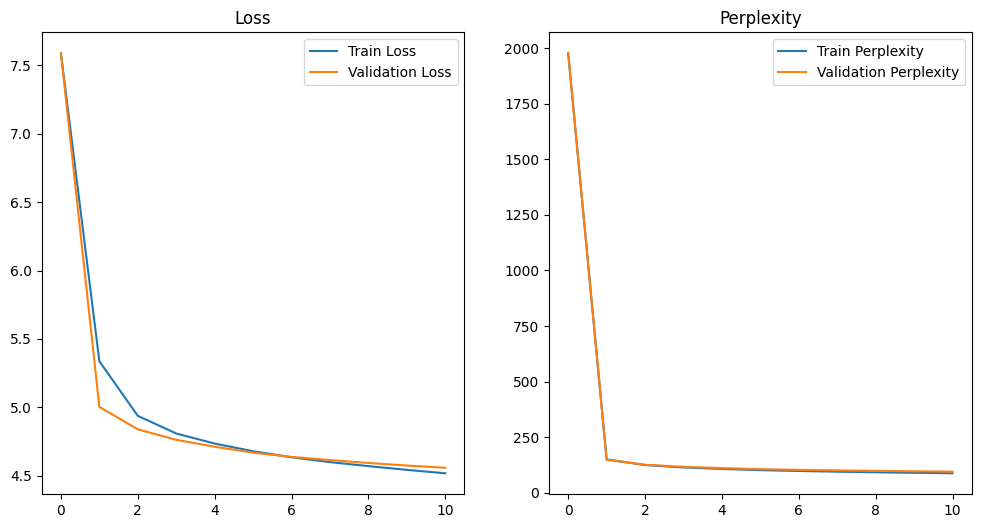

In [34]:
from torch import optim
import matplotlib.pyplot as plt

# Definição dos hiperparâmetros
epochs = 10  # Número de épocas de treinamento
lr = 3e-5  # Taxa de aprendizado
penalty = 1e-2  # Penalidade de regularização (weight decay)

# Configuração da função de perda e do otimizador
criterion = nn.CrossEntropyLoss()  # Função de perda para problemas de classificação
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=penalty)  # Otimizador AdamW com regularização

# Inicializa as listas de perdas de treinamento e validação com as perdas iniciais
train_loss = [helper.validate(train_loader, criterion)]
val_loss = [helper.validate(val_loader, criterion)]

# Inicializa as listas de perplexidade de treinamento e validação
train_perplexity = [perplexity(helper, train_loader)]
val_perplexity = [perplexity(helper, val_loader)]

# Loop de treinamento por época
for ep in range(epochs):
    # Treinamento para uma época
    t_loss = helper.train_epoch(train_loader, criterion, optimizer)

    # Validação após a época de treinamento
    v_loss = helper.validate(val_loader, criterion)

    # Cálculo da perplexidade para o conjunto de treinamento e validação
    t_pp = perplexity(helper, train_loader)
    v_pp = perplexity(helper, val_loader)

    # Impressão das perdas e perplexidades para cada época
    print(f"Epoch {ep+1} \tTrain Loss {t_loss:.4f} \tVal Loss {v_loss:.4f} \tTrain Perplexity {t_pp:.4f} \tVal Perplexity {v_pp:.4f}")

    # Armazena as perdas e perplexidades para plotagem posterior
    train_loss.append(t_loss)
    val_loss.append(v_loss)
    train_perplexity.append(t_pp)
    val_perplexity.append(v_pp)

# Plotagem das curvas de perda de treinamento e validação
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(len(train_loss)), train_loss, label="Train Loss")
plt.plot(range(len(train_loss)), val_loss, label="Validation Loss")
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(len(train_perplexity)), train_perplexity, label="Train Perplexity")
plt.plot(range(len(train_perplexity)), val_perplexity, label="Validation Perplexity")
plt.title("Perplexity")
plt.legend()

plt.show()


## Avaliação

In [35]:
# Calcula a perplexidade no conjunto de treinamento
train_pp = perplexity(helper, train_loader)

# Calcula a perplexidade no conjunto de validação
val_pp = perplexity(helper, val_loader)

# Exibe as perplexidades calculadas com quatro casas decimais
print(f"Train Perplexity: {train_pp:.4f}")
print(f"Val Perplexity: {val_pp:.4f}")


Train Perplexity: 87.9531
Val Perplexity: 95.3453


## Exemplo de uso

In [41]:
class TextGenerator:

    unknown_word = "#?"  # Token para palavras desconhecidas

    def __init__(self, model: LanguageModel, tokenizer: Tokenizer, device):
        self.model = model.to(device)  # Move o modelo para o dispositivo especificado (CPU ou GPU)
        self.tokenizer = tokenizer  # Tokenizador para converter texto em tokens e vice-versa
        self.device = device  # Dispositivo para executar o modelo
        self._token_ids = {i: word for word, i in tokenizer.items()}  # Mapeamento de IDs de tokens para palavras

    def decode(self, tokens: Sequence[int]) -> str:
        """
        Converte uma sequência de tokens em uma string de texto legível.
        """
        words = [self._token_ids.get(token, self.unknown_word) for token in tokens]  # Decodifica tokens para palavras
        text = ""

        for i, word in enumerate(words):
            next_word = words[i+1] if i+1 < len(words) else ""  # Obtém a próxima palavra
            if next_word.isalpha() or next_word == self.unknown_word:
                text += f"{word} "  # Adiciona espaço entre palavras alfanuméricas
            else:
                text += word  # Junta pontuação diretamente sem espaço

        return text.strip()  # Remove espaços em branco extras no final

    def safe_encode(self, text: str, context_size: int) -> Sequence[int]:
        """
        Codifica o texto em tokens com padding e truncamento seguro.
        """
        tokens = self.tokenizer.encode(text)  # Converte texto em tokens
        padding = [0] * context_size  # Prepara padding à esquerda
        return (padding + tokens)[-context_size:]  # Aplica padding ou truncamento para ajustar ao tamanho do contexto

    def generate(self, text: str, max_length: int) -> str:
        """
        Gera texto continuando a partir do texto fornecido até o comprimento máximo.
        """
        context_size = self.model.params.context_size  # Tamanho do contexto definido no modelo
        tokens = self.safe_encode(text, context_size)  # Prepara os tokens iniciais com padding ou truncamento
        self.model.eval()  # Coloca o modelo em modo de avaliação

        for _ in range(max_length):
            context = torch.tensor([tokens[-context_size:]], dtype=torch.long, device=self.device)  # Prepara o contexto
            logits = self.model(context)  # Gera previsões para o próximo token
            next_token = logits.argmax(dim=1).item()  # Seleciona o token mais provável
            tokens.append(next_token)  # Adiciona o token gerado à sequência

        return self.decode(tokens)  # Decodifica a sequência de tokens gerados em texto

    def __call__(self, text: str, max_length: int) -> str:
        """
        Permite que o objeto seja chamado como uma função para gerar texto.
        """
        return self.generate(text, max_length)


In [42]:
generator = TextGenerator(model, tokenizer, device)
max_length = 64

texts = [
    "Era um rapaz de vinte e cinco",
    "afabilidade de uns"
]

for i, text in enumerate(texts, 1):
    s = generator(text, max_length)
    print(f"{i}.", s)
    print("")


1. rapaz de vinte e cinco anos, e a sua mãe, e a sua mãe, e a sua mãe, e a sua mãe, e a sua mãe, e a sua mãe, e a sua mãe, e a sua mãe, e a sua mãe, e a sua mãe, e a sua mãe, e a sua mãe, e a

2. #? #? #? de uns olhos, e a sua mãe, e a sua mãe, e a sua mãe, e a sua mãe, e a sua mãe, e a sua mãe, e a sua mãe, e a sua mãe, e a sua mãe, e a sua mãe, e a sua mãe, e a sua mãe, e a

